In [1]:
# importing modules
import os
import numpy as np
import mne

In [2]:
# loading data
raw = mne.io.read_raw_brainvision("58044/Group5/Group5_own.vhdr", eog=('EOG1', 'EOG2'))
raw.load_data()

raw

Extracting parameters from 58044/Group5/Group5_own.vhdr...
Setting channel info structure...
Reading 0 ... 599719  =      0.000 ...   599.719 secs...


<RawBrainVision | Group5_own.eeg, 32 x 599720 (599.7 s), ~146.5 MB, data loaded>

In [3]:
# specyfing the channel location using the montage related functions
montage = mne.channels.make_standard_montage('standard_1020')

raw.set_montage(montage, verbose=False)

<RawBrainVision | Group5_own.eeg, 32 x 599720 (599.7 s), ~146.5 MB, data loaded>

In [4]:
#redefining reference to a common average
raw.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | Group5_own.eeg, 32 x 599720 (599.7 s), ~146.5 MB, data loaded>

Using matplotlib as 2D backend.
Opening raw-browser...


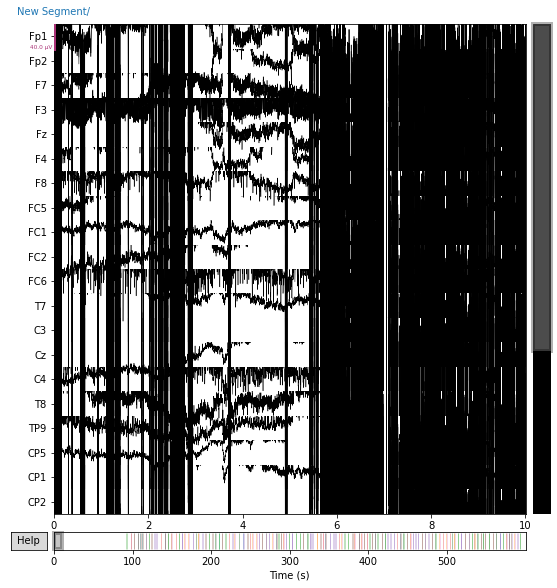

In [5]:
# default plot function
raw.pick_types(meg=False, eeg=True, stim=True)
raw.plot();

Opening raw-browser...


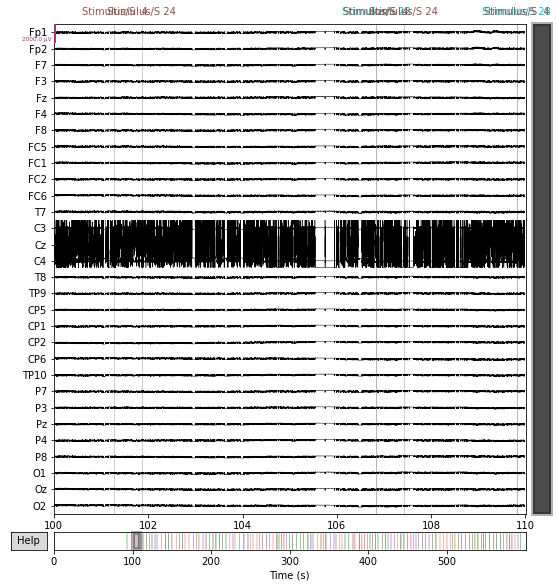

In [6]:
# choosing all channels and scaling (set to auto for now) 
raw.pick_types(meg=False, eeg=True, stim=True)
raw.plot(n_channels = 32, scalings = dict(eeg=100e-5, eog=150e-6), start=100, duration=10);

In [7]:
# f*ck central zentrum (Defining bad channels) 
raw.info['bads'] = ['Cz']
raw.pick_types(meg=False, eeg=True, stim=True, exclude='bads')

<RawBrainVision | Group5_own.eeg, 29 x 599720 (599.7 s), ~132.7 MB, data loaded>

Opening raw-browser...


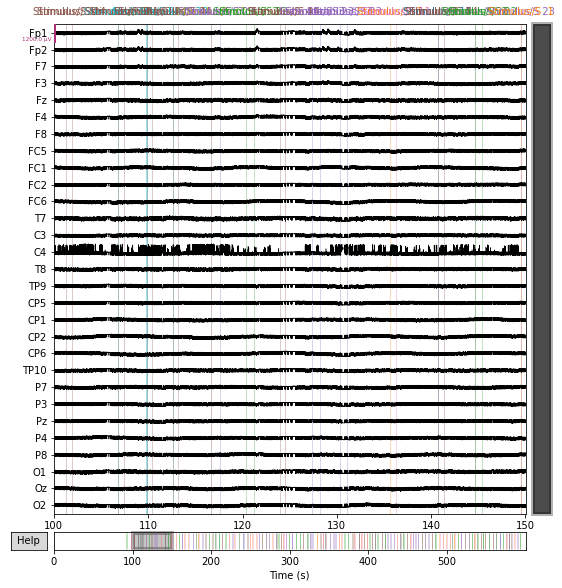

In [8]:
raw.plot(n_channels = 32, scalings = dict(eeg=600e-6, eog=150e-6), start = 100, duration = 50);

In [9]:
# Also f*ck C4
raw.info['bads'] = ['C4']
raw.pick_types(meg=False, eeg=True, stim=True, exclude='bads')

<RawBrainVision | Group5_own.eeg, 28 x 599720 (599.7 s), ~128.2 MB, data loaded>

Opening raw-browser...


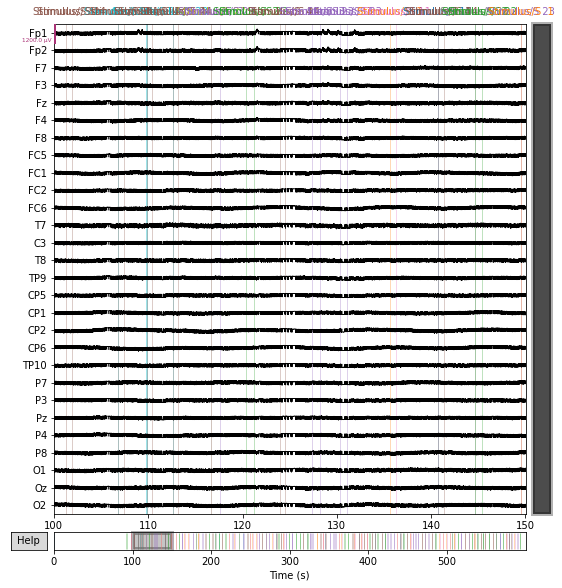

In [10]:
raw.plot(n_channels = 32, scalings = dict(eeg=600e-6, eog=150e-6), start = 100, duration = 50);

## DOING ICA

In [11]:
# set up and fit the ica with 800 iterations with a random seed at 97
# n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data
ica = mne.preprocessing.ICA(n_components=0.95, random_state=98, max_iter=800)
ica.fit(raw)

Fitting ICA to data using 28 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 4.1s.


Method,fastica
Fit,12 iterations on raw data (599720 samples)
ICA components,5
Explained variance,95.2 %
Available PCA components,28
Channel types,eeg
ICA components marked for exclusion,—


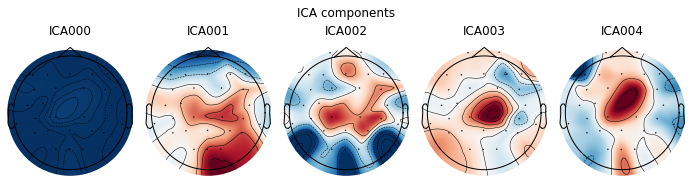

In [12]:
ica.plot_components();

The first ICA is very not good so therefore we inspect it closer

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


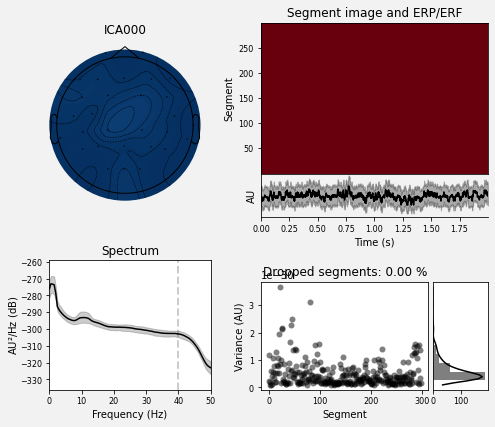

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


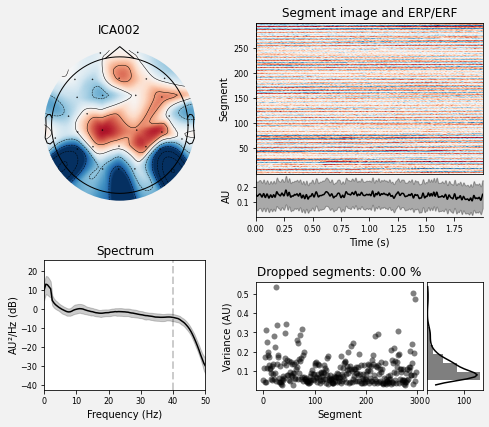

In [31]:
# the first component is excluded based on visual inspection
ica.exclude = [0]
ica.plot_properties(raw, picks=ica.exclude);

## further inspection of ICA002
ica.plot_properties(raw, picks=[2]);

In [14]:
# applying the ica to the data
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 28 PCA components


<RawBrainVision | Group5_own.eeg, 28 x 599720 (599.7 s), ~128.2 MB, data loaded>

Opening raw-browser...


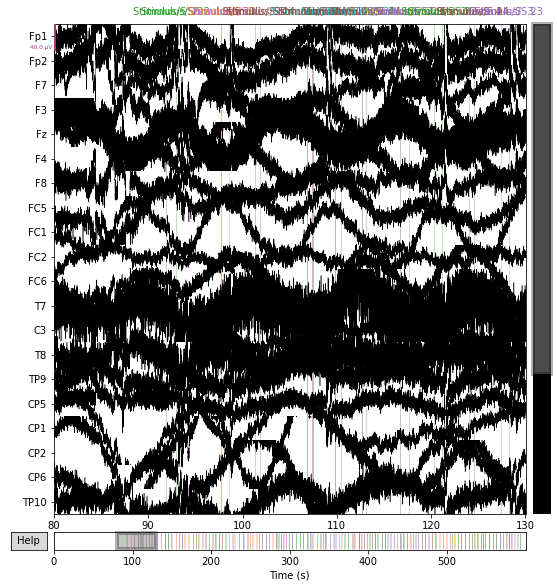

In [15]:
# seeing what the ICA did for us
raw.plot(start = 80, duration = 50);

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 sec)

Opening raw-browser...


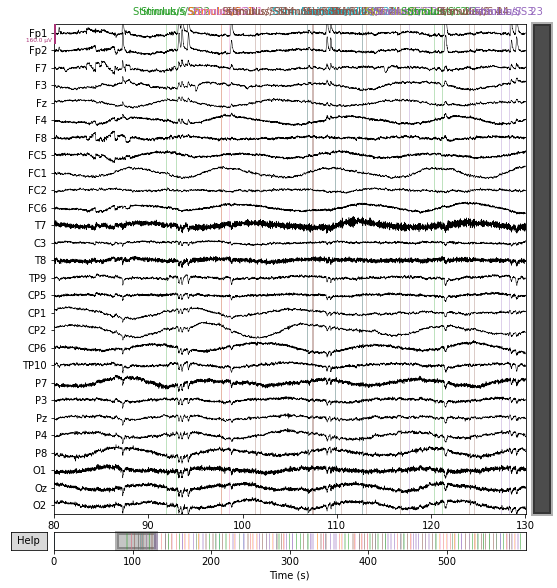

In [16]:
raw = raw.filter(0.1, 40) #high-pass filtering at 0.1 Hz, and low-pass filtering at 40 hZ. 

raw.plot(n_channels = 32, scalings = dict(eeg=80e-6, eog=150e-6), start=80, duration = 50);

## CODING IN TRIGGERS / EVENTS

In [17]:
# extracting the triggers
info = mne.events_from_annotations(raw)

# isolating all events 
events = info[0]

# uniques?
event_id_np = np.unique(events[:,2])
event_id_np

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 26', 'Stimulus/S 27', 'Stimulus/S 28']


array([    1,     2,     3,     4,    11,    12,    13,    14,    15,
          21,    22,    23,    24,    25,    26,    27,    28, 99999])

In [18]:
# setting up event dictionary 
event_id = {'Word/Real': 1,
            'Word/CenterShuffled': 2, 
            'Word/FullyShuffled': 3, 
            'Word/Foreign': 4,
            'Decision/YesReal': 11,
            'Decision/YesCenter': 12,
            'Decision/YesFully': 13,
            'Decision/YesForeign': 14, 
            'Decision/NoReal': 21, 
            'Decision/NoCenter': 22,
            'Decision/NoFully': 23,  
            'Decision/NoForeign': 24,
            '15': 15,
            '25': 25, 
            '26': 26, 
            '27': 27,
            '28': 28,
            '99999': 99999
           }

# setting up FALSE event dictionary 
event_id_FALSE = {'15': 15,
            '25': 25, 
            '26': 26, 
            '27': 27,
            '28': 28,
            '99999': 99999, 
           }

/tmp/ipykernel_278/2862750187.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);


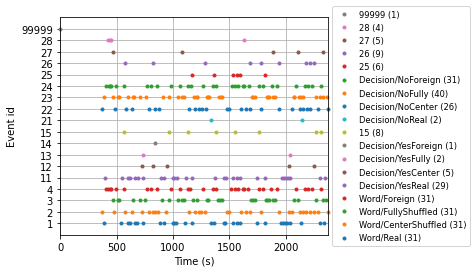

In [19]:
# plotting the events 
mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);

## EPOCHING

In [20]:
# setting time window 
tmin, tmax = -0.1, 0.7

# choosing only EEG channels for epoching (thus EOG false) 
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False)

#reject criterion of 150 microvolts
reject = dict(eeg=150e-6)

# epochs 
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
293 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 293 events and 801 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
8 bad epochs dropped


Only 8 out of 293 epochs have been dropped *dab*

## DOWNSAMPLING

In [21]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

## ERP TIME

In [22]:
word_epochs = epochs_resampled['Word']
decision_epochs = epochs_resampled['Decision']

Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


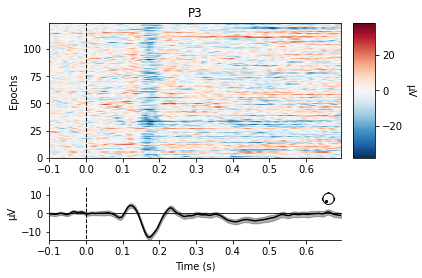

Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


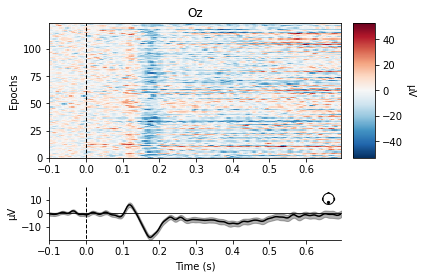

Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


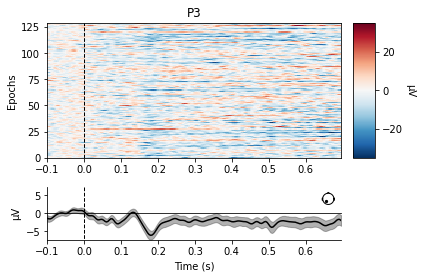

In [23]:
word_epochs.plot_image(picks=["P3"]); # a bit behind wernickes area
word_epochs.plot_image(picks=["Oz"]); # occipital lobe, all the way at the back of the head

decision_epochs.plot_image(picks=["P3"]);

In [24]:
# Looking at the difference of the word types
word_real_epochs = epochs_resampled['Word/Real']
word_cs_epochs = epochs_resampled['Word/CenterShuffled']
word_fs_epochs = epochs_resampled['Word/FullyShuffled']
word_foreign_epochs = epochs_resampled['Word/Foreign']


word_real_evoked = word_real_epochs.average()
word_cs_evoked = word_cs_epochs.average()
word_fs_evoked = word_fs_epochs.average()
word_foreign_evoked = word_foreign_epochs.average()


No projector specified for this dataset. Please consider the method self.add_proj.


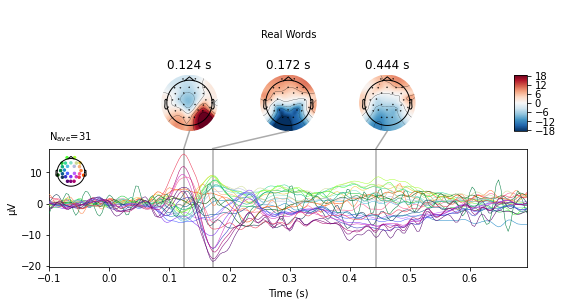

No projector specified for this dataset. Please consider the method self.add_proj.


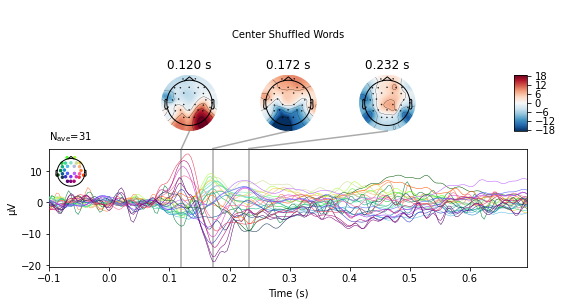

No projector specified for this dataset. Please consider the method self.add_proj.


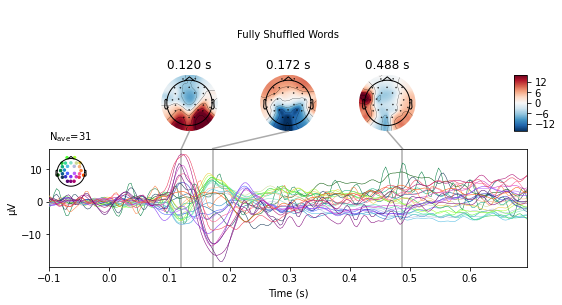

No projector specified for this dataset. Please consider the method self.add_proj.


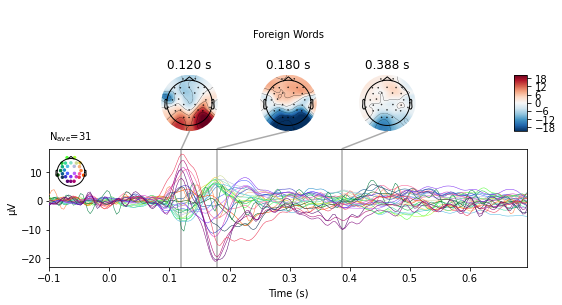

In [25]:
#categorising
word_real_plot = word_real_evoked.plot_joint(picks='eeg', title = "Real Words");

word_cs_plot = word_cs_evoked.plot_joint(picks='eeg', title = "Center Shuffled Words");

word_fs_plot = word_fs_evoked.plot_joint(picks='eeg', title = "Fully Shuffled Words");

word_foreign_plot = word_foreign_evoked.plot_joint(picks='eeg', title = "Foreign Words");

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


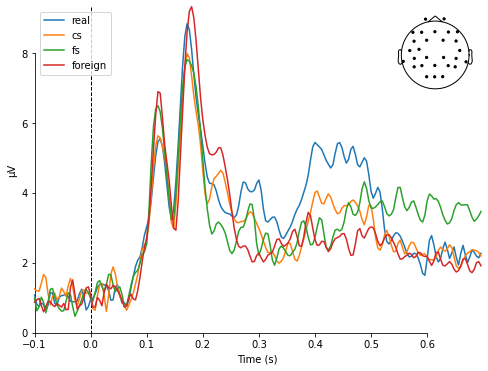

[<Figure size 576x432 with 2 Axes>]

In [32]:
#all evokeds in a dict
evokeds = dict(real=word_real_evoked, cs=word_cs_evoked, fs = word_fs_evoked, foreign = word_foreign_evoked)

# plotting the two evokeds together
mne.viz.plot_compare_evokeds(evokeds, legend='upper left', show_sensors='upper right')

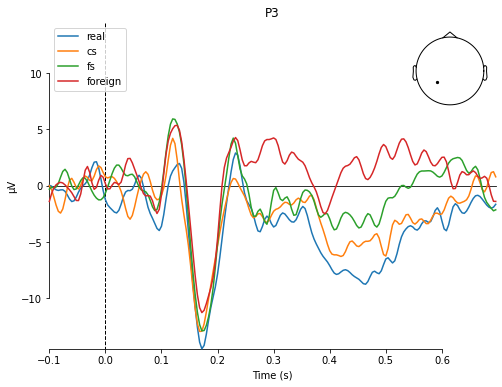

In [37]:
p3_evoked_plot = mne.viz.plot_compare_evokeds(evokeds, picks='P3')
p3_evoked_plot
p3_evoked_plot[0].savefig(fname = "p3_evoked_plot")

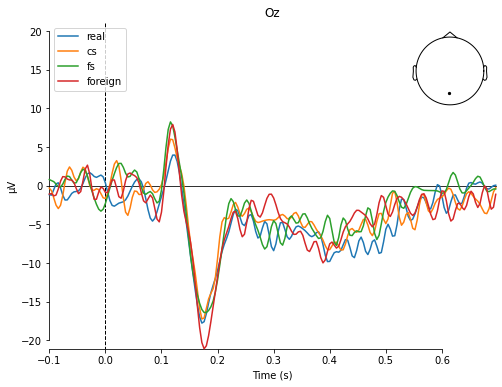

[<Figure size 576x432 with 2 Axes>]

In [38]:
mne.viz.plot_compare_evokeds(evokeds, picks='Oz')

## STATS 

In [ ]:
# importing modules
import os
import pip
!python -m pip install mne
os.system('python -m pip install scikit-learn')
import numpy as np
import pandas as pd
import mne

In [44]:
#saving our EPOCHS as an object
epochs_resampled.save('group5_epochs-epo.fif')

In [45]:
all_epochs = mne.read_epochs('group5_epochs-epo.fif')

Reading /work/group5_epochs-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     696.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
285 matching events found
No baseline correction applied
0 projection items activated


In [46]:
word_epochs = all_epochs['Word']
decision_epochs = all_epochs['Decision']

## Windowed mean
One of the simplest way in which we can determine whether the signal in our two conditions are statistically significant is by:

1) Segmenting our data using only certain channels in a specific time window. Keep in mind that which time window and channels should be established a priori, for instance according to the literature. 
2) Taking the mean of that window across channels and and samples.
3) Running statistical tests on the windowed means from the two conditions.

In an experiment with multiple participants we would also average over trials from individual participants, in order to only have one data point per participant (and thereby avoid multiple comparisons). However, since we have one participant, we can keep one dimension of the individual data, i.e. the trials.

### T-test
We can now do a t-test on the trials from the two conditions, to establish whether the means of the two groups are statistically significant.

We can use the get_data() function to get the numerical values of the signal (in microvolts) for the t-test. tmin and tmax are used to define the size of the window, and the picks are the channels that we expect to see an effect in.